# Neural Netowork Regression Predictions

AFKATM, Uton Hackathon 2019

<img src="image.png" width="420" height="200">

In [53]:
import pandas as pd
import numpy as np
import datetime as dt

from keras.layers import Input, Dense, Dropout, Concatenate
from keras.models import Model
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import keras.backend as K

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load the clean data set

In [29]:
df = pd.read_csv('data_clean.csv')
df = df.set_index('date')
df.index = df.index.astype('datetime64')

In [30]:
df.head()

,atm_name,withdrawals_total,withdrawals_xyz,withdrawals_other,amount_total,amount_xyz,amount_other,weekday,festival,working_day
date,,,,,,,,,,
2011-01-01,KK Nagar ATM,265.0,159.0,106.0,945300.0,532600.0,412700.0,6,C,0.0
2011-01-01,Airport ATM,98.0,56.0,42.0,503400.0,347700.0,155700.0,6,C,0.0
2011-01-01,Christ College ATM,74.0,25.0,49.0,287700.0,148200.0,139500.0,6,C,0.0
2011-01-01,Big Street ATM,50.0,20.0,30.0,123800.0,41700.0,82100.0,6,H,0.0
2011-01-01,Mount Road ATM,253.0,67.0,186.0,767900.0,270900.0,497000.0,6,C,0.0


## Define a function for generating features out of the existing ones:

- Tomorrow's `amount_total` as target
- Tomorrow's `festival` and `working_day` because we know them beforehand
- Today's `withdrawal_total`, `withdrawal_xyz`, `withdrawal_other`, `amount_total`, `amount_xyz`, `amount_other` and their historical value if necessary
- The average amount per withdrawal in general, for xyz only and for others

In [31]:
# generate features from a temp_df with shift=depth (start from 0!)

def create_historical_features(temp, depth):
    return {
        f'weekday_{depth}': temp.weekday.astype('float').shift(depth - 1),
        f'festival_{depth}': temp.festival.shift(depth - 1),
        f'working_day_{depth}': temp.working_day.astype('float').shift(depth - 1),
        f'withdrawals_total_{depth}': temp.withdrawals_total.astype('float').shift(depth),
        f'withdrawals_xyz_{depth}': temp.withdrawals_xyz.astype('float').shift(depth),
        f'withdrawals_other_{depth}': temp.withdrawals_other.astype('float').shift(depth),
        f'amount_total_{depth}': temp.amount_total.astype('float').shift(depth),
        f'amount_xyz_{depth}': temp.amount_xyz.astype('float').shift(depth),
        f'amount_other_{depth}': temp.amount_other.astype('float').shift(depth),
        f'amount_withdrawals_total_{depth}': temp.amount_total.astype('float').shift(depth) / temp.withdrawals_total.astype('float').shift(depth),
        f'amount_withdrawals_xyz_{depth}': temp.amount_xyz.astype('float').shift(depth) / temp.withdrawals_xyz.astype('float').shift(depth),
        f'amount_withdrawal_other_{depth}': temp.amount_other.astype('float').shift(depth) / temp.withdrawals_other.astype('float').shift(depth),
    }

## Define a custom loss function for the neural network

In [32]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

## Train the models and save the test predictions

In [72]:
def train_atm(atm, df):
    print('\n' + '=' * 50)
    print(atm + '\n')
    
    temp = df[df.atm_name == atm]
    
    features = {
        'target': temp.amount_total.astype('float').shift(-1),
        'atm_name': temp.atm_name
    }
    for depth in range(4):
        features_depth = create_historical_features(temp, depth)
        for key, value in features_depth.items():
            features[key] = value
    
    train_df = pd.DataFrame(features)
    train_df = train_df.sort_index().dropna()
    
    train = train_df[train_df.index <= train_df.index.max() - dt.timedelta(days=365)]
    test = train_df[train_df.index > train_df.index.max() - dt.timedelta(days=365)]

    y_train = list(train.target)
    test_target = test.target
    y_test = list(test_target)

    train = train.reset_index().drop(columns=['target', 'date'])
    test = test.reset_index().drop(columns=['target', 'date'])
    
    # encode categorical features
    cat_features = [c for c in train.columns if train[c].dtype == 'object']
    for c in cat_features:
        for v in set(train[c]):
            train[c + '_' + v] = 0
            train[c + '_' + v][train[c] == v] = 1
            
            test[c + '_' + v] = 0
            test[c + '_' + v][test[c] == v] = 1
            
        train = train.drop(columns=[c])
        test = test.drop(columns=[c])
    
    inputs = Input(shape=(train.shape[1],))
    fc1 = Dense(64, activation='relu')(inputs)
    fc1 = Dropout(0.4)(fc1)
    fc1 = Concatenate()([fc1, inputs])
    fc2 = Dense(64, activation='relu')(fc1)
    fc2 = Dropout(0.4)(fc2)
    outputs = Dense(1)(fc2)
    model = Model(inputs=[inputs], outputs=[outputs])
    
    model.compile(optimizer=RMSprop(),
                  loss=root_mean_squared_error)
    es = EarlyStopping(monitor='val_loss', 
                       mode='min',
                       restore_best_weights=True, 
                       patience=15)
    model.fit(
        train, y_train,
        validation_data=(test, y_test),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )
    test_prediction = model.predict(test)
    
    print('Model trained.')
    
    return model, train_df, test_target, test_prediction

In [73]:
models = {}
test_predictions = {}
test_trues = {}
train_features = {}

for atm in list(set(df.atm_name)):
    model, train_df, test_true, test_prediction = train_atm(atm, df)
    models[atm] = model
    test_predictions[atm] = test_prediction
    test_trues[atm] = test_true
    train_features[atm] = train_df


Airport ATM

Model trained.

KK Nagar ATM

Model trained.

Mount Road ATM

Model trained.

Christ College ATM

Model trained.

Big Street ATM

Model trained.


## Feature correlation for each model

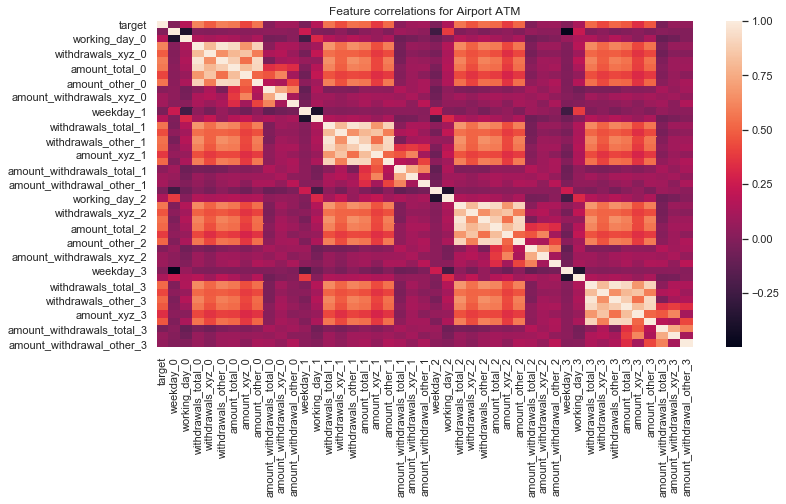

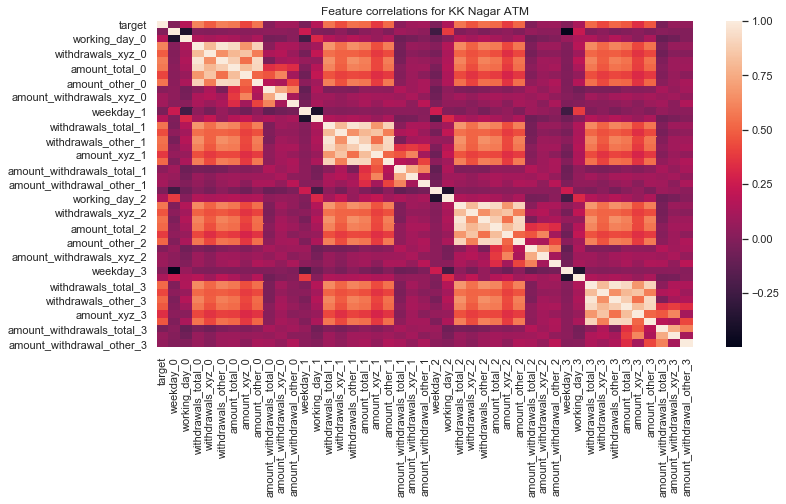

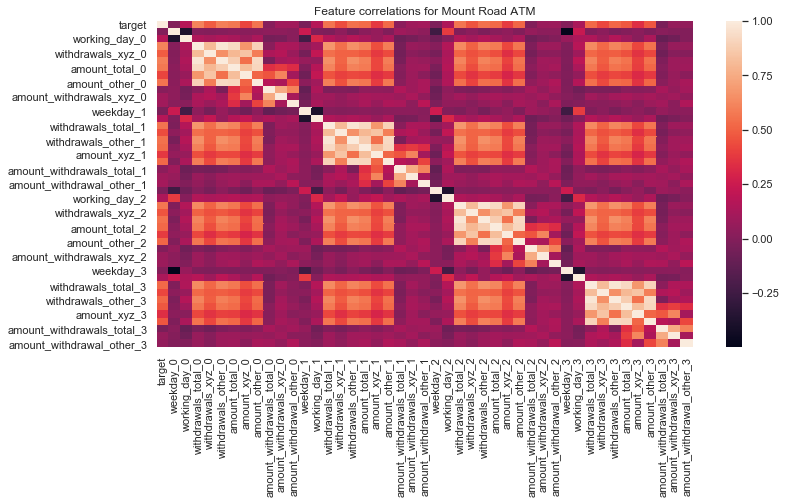

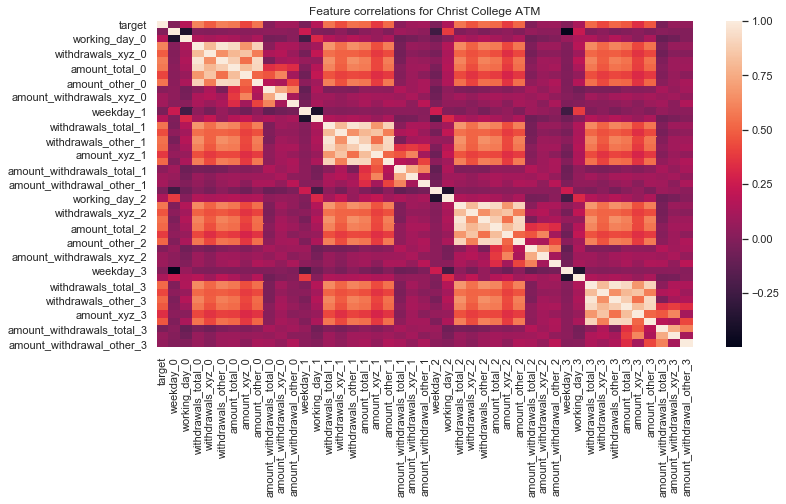

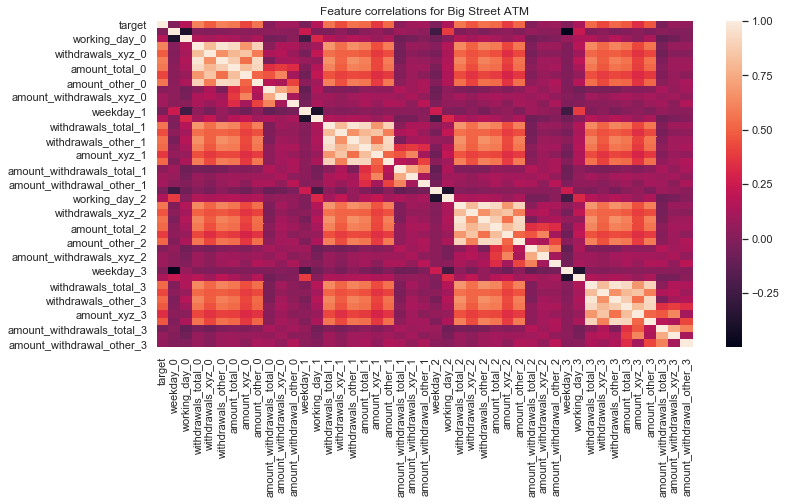

In [74]:
for atm in set(df.atm_name):
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_df.corr()).set_title(f'Feature correlations for {atm}')

## RMSE and prediction vs. actual value for the test set (last 1 year)

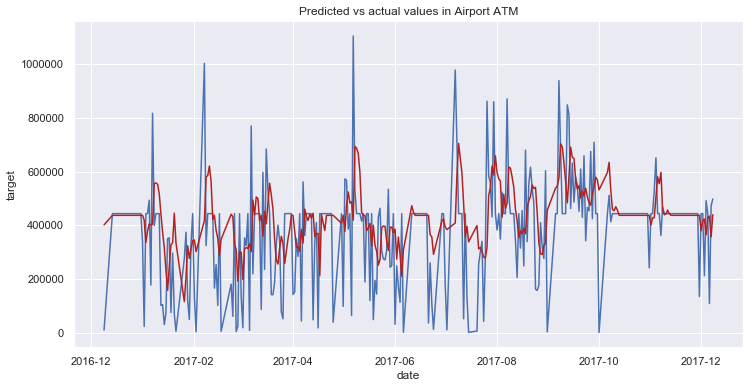

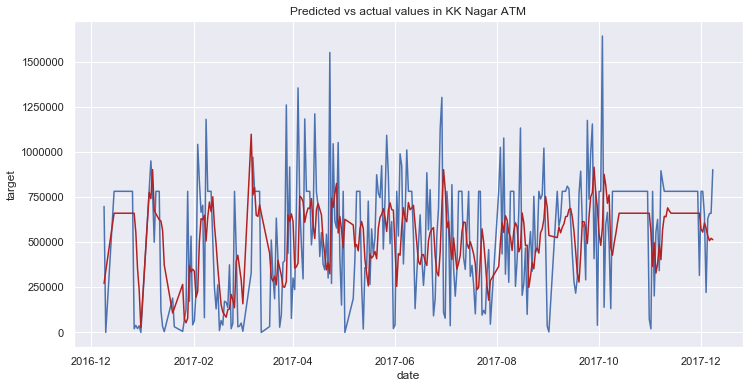

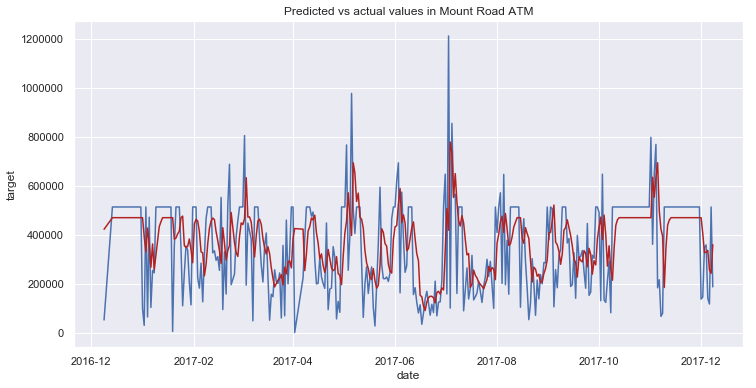

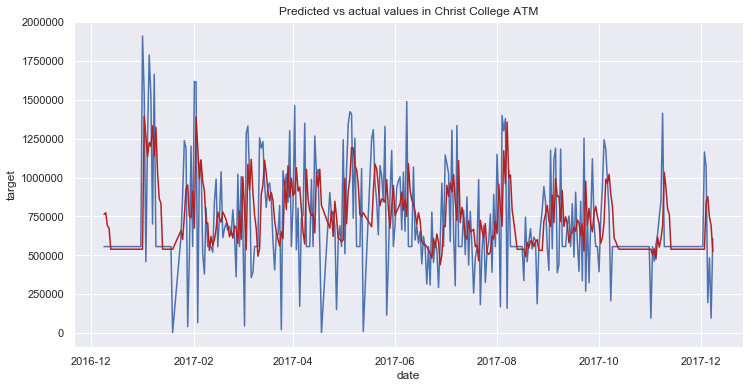

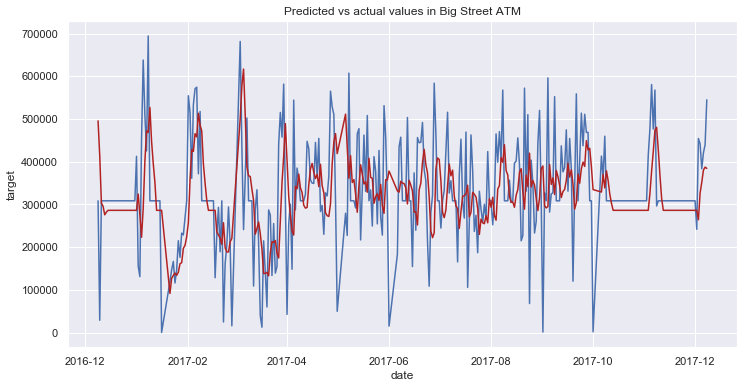

In [75]:
rmse = []

for atm in set(df.atm_name):
    plt.figure(figsize=(12, 6))

    sns.lineplot(x=test_trues[atm].index, y=test_trues[atm])
    sns.lineplot(x=test_trues[atm].index, y=test_predictions[atm].reshape(-1), color='firebrick').set_title(f'Predicted vs actual values in {atm}')
    
    rmse.append(
        np.mean(np.power(np.power(np.array(test_trues[atm]) - test_predictions[atm].reshape(-1), 2), 0.5))
    )

In [76]:
print(f'The ovarall RMSE is {sum(rmse) / len(rmse)}')

The ovarall RMSE is 168347.85096274735


## Example section below [Deprecated]

In [ ]:
# First ATM example

atm = 'Mount Road ATM'
temp = df[df.atm_name == atm]
    
features = {
    'target': temp.amount_total.astype('float').shift(-1),
    'atm_name': temp.atm_name
}
for depth in range(4):
    features_depth = create_historical_features(temp, depth)
    for key, value in features_depth.items():
        features[key] = value

train_df = train_df.append(pd.DataFrame(features))
train_df = train_df.sort_index().dropna()

train = train_df[train_df.index <= train_df.index.max() - dt.timedelta(days=365)]
test = train_df[train_df.index > train_df.index.max() - dt.timedelta(days=365)]

In [ ]:
train.target.plot(figsize=(20, 10))